In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
train_data = pd.read_csv('/kaggle/input/titanic/train.csv')
test_data = pd.read_csv('/kaggle/input/titanic/test.csv')
submission = pd.read_csv('/kaggle/input/titanic/gender_submission.csv') 

# 1. Data Understanding

In [3]:
print('shape of training data: {}'.format(train_data.shape))
print('shape of test data: {}'.format(test_data.shape))

shape of training data: (891, 12)
shape of test data: (418, 11)


In [4]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
train_data.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [8]:
train_data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [9]:
test_data.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [10]:
train_data.loc[train_data.duplicated()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


In [11]:
train_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [12]:
print('Number of unique values:\n{}'.format(train_data.nunique()))

Number of unique values:
PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64


# 2. Data Preparation

In [13]:
train_data.select_dtypes(exclude='object').columns

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')

Ordinal encoding on age Sex and Embarked 

In [14]:
train_data[train_data['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [15]:
train_data.groupby(['Sex', 'Embarked']).median()

/tmp/ipykernel_20/2523321316.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  train_data.groupby(['Sex', 'Embarked']).median()


PassengerId  Survived  Pclass   Age  SibSp  Parch      Fare
Sex    Embarked                                                             
female C               381.0       1.0     1.0  24.0    0.0    0.0  56.92920
       Q               327.0       1.0     3.0  21.5    0.0    0.0   7.76875
       S               433.0       1.0     2.0  27.0    0.0    0.0  24.15000
male   C               496.0       0.0     2.0  30.0    0.0    0.0  24.00000
       Q               460.0       0.0     3.0  30.0    0.0    0.0   7.75000
       S               461.0       0.0     3.0  28.0    0.0    0.0  10.50000

there are just 2 missing values in Enbarked we can impute them as C as it seems like the most likely port 

In [16]:
train_data['Embarked'] = train_data['Embarked'].fillna('C')

In [17]:
train_data.loc[61]

PassengerId                     62
Survived                         1
Pclass                           1
Name           Icard, Miss. Amelie
Sex                         female
Age                           38.0
SibSp                            0
Parch                            0
Ticket                      113572
Fare                          80.0
Cabin                          B28
Embarked                         C
Name: 61, dtype: object

In [18]:
train_data['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

In [19]:
train_data['Deck'] = train_data['Cabin'].apply(lambda x: x[0] if pd.notnull(x) else 'M')
test_data['Deck'] = test_data['Cabin'].apply(lambda x:x[0] if pd.notnull(x) else 'M')
train_data['Deck'].unique()

array(['M', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [20]:
train_data.drop('Cabin', axis = 1, inplace = True)
test_data.drop('Cabin', axis = 1, inplace = True)

Cabin values, missing ones are replaced with M

In [21]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [22]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Deck
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,M
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,M
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,M


<Axes: >

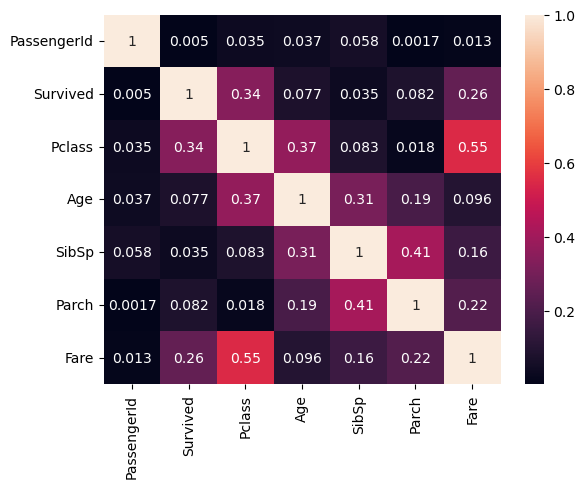

In [23]:
df_corr = train_data.corr(numeric_only = True).abs()
sns.heatmap(df_corr, annot= True)

In [24]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


1. impute age values by median of group by of pclass and number of siblings as they show the most coorelation with age
2. avoid data leakage from train data to test data

In [25]:
train_data['Age'] = train_data.groupby(['Pclass','Sex'])['Age'].transform(lambda x: x.fillna(x.median()))
test_data['Age'] = test_data.groupby(['Pclass','Sex'])['Age'].transform(lambda x: x.fillna(x.median()))

In [26]:
train_data[train_data['Age'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Deck


In [27]:
test_data.loc[test_data['Fare'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Deck
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,S,M


In [28]:
test_data.groupby(['Pclass']).mean()['Fare']

/tmp/ipykernel_20/3763112516.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  test_data.groupby(['Pclass']).mean()['Fare']


Pclass
1    94.280297
2    22.202104
3    12.459678
Name: Fare, dtype: float64

In [29]:
test_data['Fare'].loc[152] = 13

/tmp/ipykernel_20/1164154705.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Fare'].loc[152] = 13


In [30]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Embarked     891 non-null    object 
 11  Deck         891 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [31]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          418 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         418 non-null    float64
 9   Embarked     418 non-null    object 
 10  Deck         418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


# 3. Feature Understanding

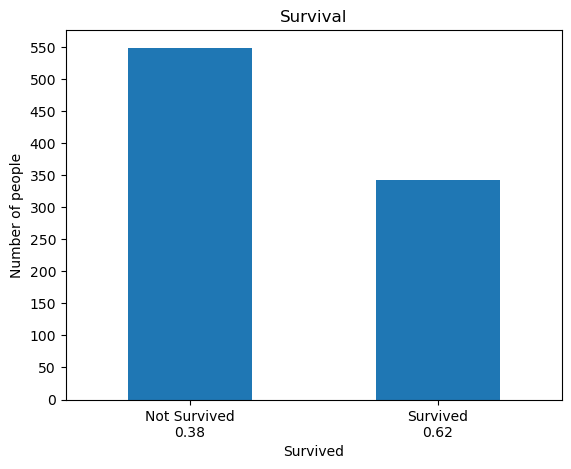

In [32]:
survived = train_data['Survived'].value_counts()[1]
not_survived = train_data['Survived'].value_counts()[0]

perc_sur = survived/train_data.shape[0]
perc_not = not_survived/train_data.shape[0]

ax = train_data['Survived'].value_counts().plot(kind='bar')
ax.set_xlabel('Survived')
ax.set_ylabel('Number of people')
ax.set_title('Survival')
ax.set_yticks(np.arange(0,600,50))
ax.set_xticks((0,1),['Not Survived\n{0:.2f}'.format(perc_sur), 'Survived\n{0:.2f}'.format(perc_not)], rotation= 0)

plt.show()

In [33]:
train_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked', 'Deck'],
      dtype='object')

<Axes: >

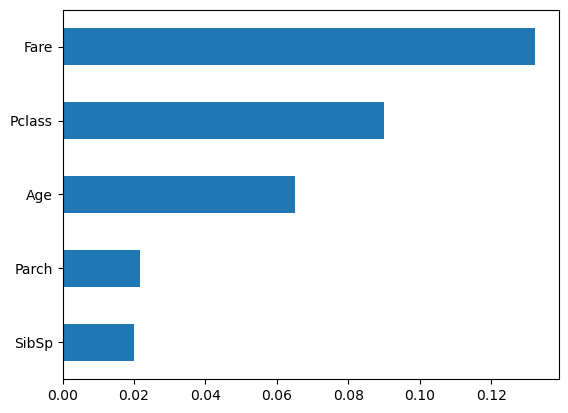

In [34]:
mutual = mutual_info_classif(train_data[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']], train_data['Survived'], random_state = 42)
mutual_plot = pd.Series(mutual, ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']).sort_values()
mutual_plot.plot(kind='barh')

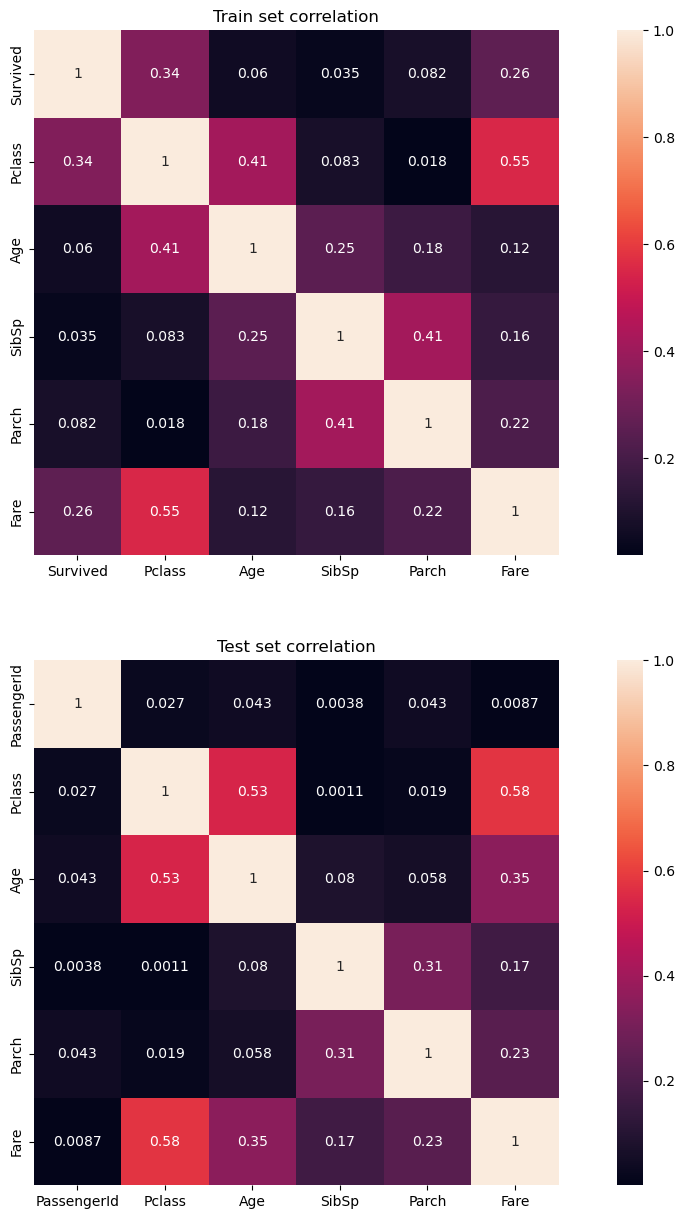

In [35]:
train_corr = train_data[['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked', 'Deck']].corr(numeric_only = True).abs()
test_corr = test_data.corr(numeric_only = True).abs()

fig ,axs = plt.subplots(nrows = 2, figsize=(15,15))
sns.heatmap(train_corr, annot = True, square = True, annot_kws = {'size' : 10}, ax = axs[0])
sns.heatmap(test_corr, annot = True, square = True , annot_kws = {'size': 10}, ax = axs[1])

axs[0].set_title('Train set correlation')
axs[1].set_title('Test set correlation')

axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=0)

plt.show()

In [36]:
corr = train_corr.unstack().sort_values(ascending = False).reset_index()

corr.columns = ['feature_1', 'feature_2', 'correspondence']
corr.drop(corr.iloc[1::2,1].index, inplace = True)
corr[(corr['correspondence'] > 0.1) & (corr['correspondence'] < 1)]

,feature_1,feature_2,correspondence
6,Fare,Pclass,0.549500
8,Parch,SibSp,0.414838
10,Age,Pclass,0.413583
12,Survived,Pclass,0.338481
14,Fare,Survived,0.257307
16,SibSp,Age,0.249854
18,Fare,Parch,0.216225
20,Age,Parch,0.175526
22,SibSp,Fare,0.159651
24,Age,Fare,0.122692


In [37]:
t_corr = test_corr.unstack().sort_values(ascending = False).reset_index()
t_corr.columns = ['Feature_1', 'Feature_2', 'correspondence']
t_corr.drop(t_corr.iloc[1::2, 1].index, inplace = True)
t_corr[(t_corr['correspondence'] > 0.1) & (t_corr['correspondence'] < 1)]

,Feature_1,Feature_2,correspondence
6,Fare,Pclass,0.577353
8,Pclass,Age,0.534379
10,Age,Fare,0.348573
12,Parch,SibSp,0.306895
14,Fare,Parch,0.230345
16,SibSp,Fare,0.171939


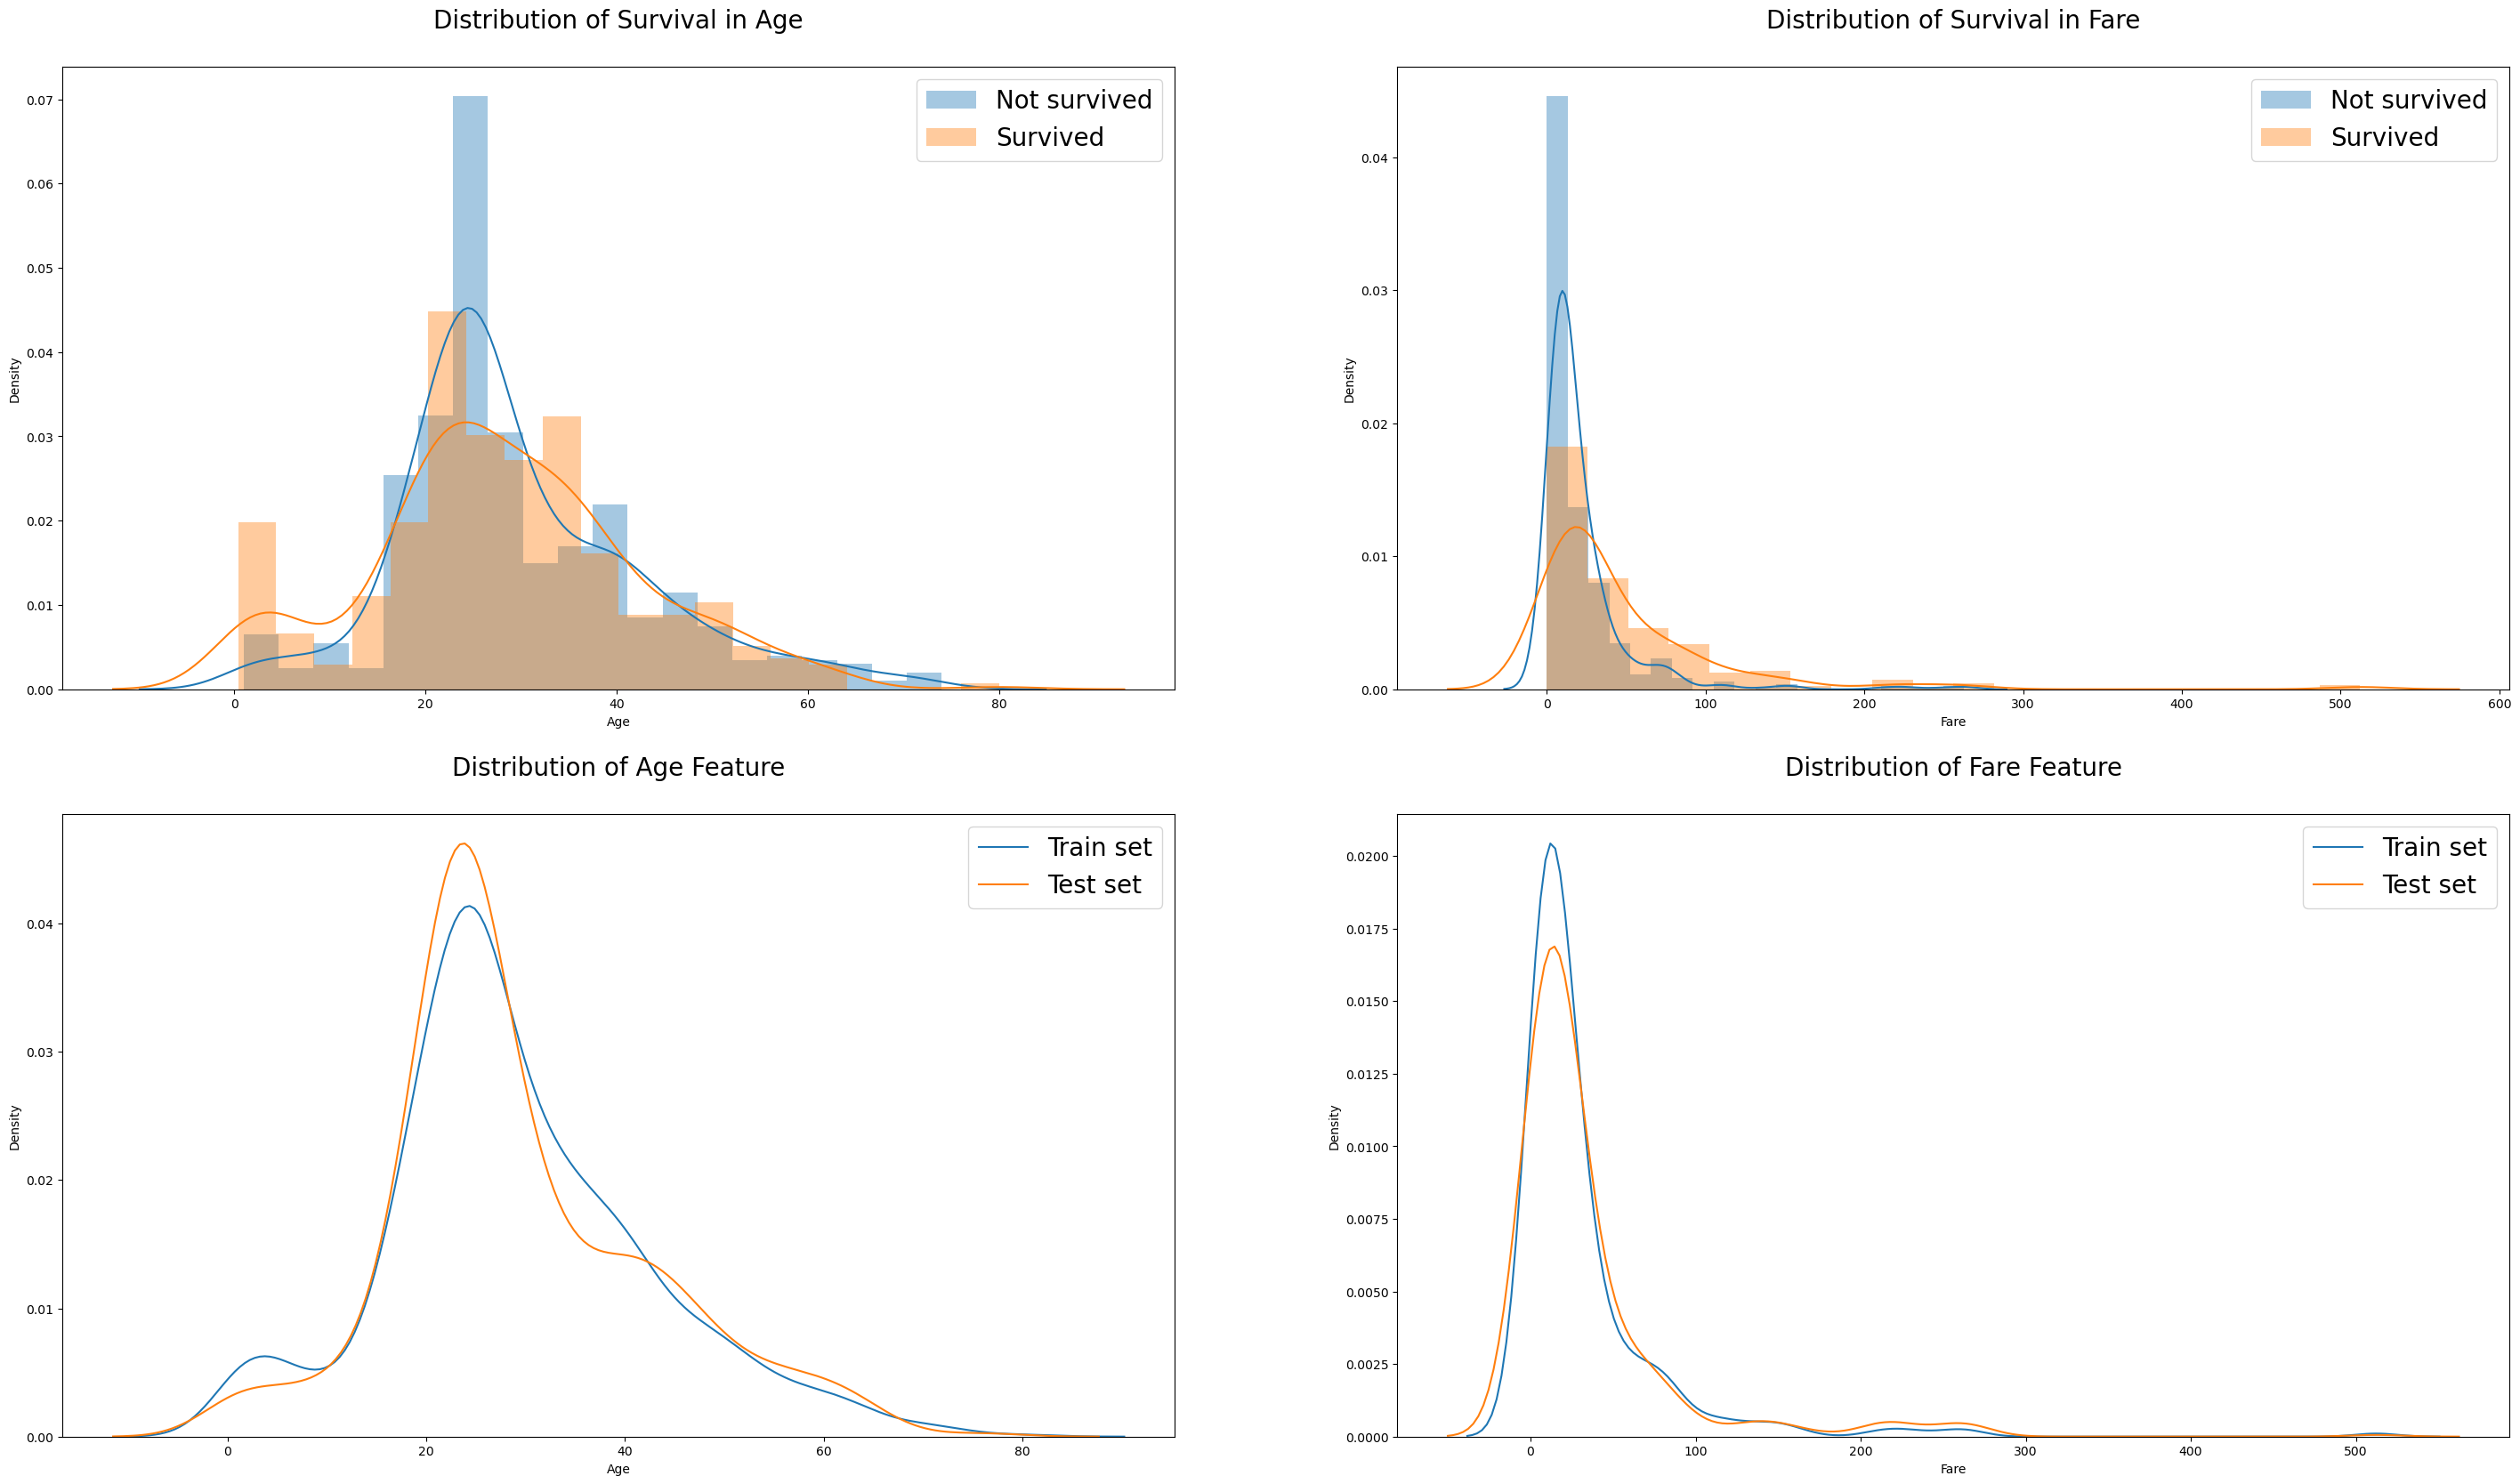

In [38]:
warnings.filterwarnings("ignore")
cont_features = ['Age', 'Fare']
surv = train_data['Survived'] == 1

fig, axs = plt.subplots(ncols = 2, nrows = 2, figsize = (20,20))
plt.subplots_adjust(right=1.5)

for i, feature in enumerate(cont_features):
    sns.distplot(train_data[~surv][feature], ax = axs[0][i], label = 'Not survived', bins = 20)
    sns.distplot(train_data[surv][feature], ax = axs[0][i], label = 'Survived', bins = 20)
    
    sns.distplot(train_data[feature], hist = False, ax = axs[1][i], label = 'Train set')
    sns.distplot(test_data[feature], hist = False, ax = axs[1][i], label = 'Test set')
    
    axs[0][i].legend(loc='upper right', prop={'size': 20})
    axs[1][i].legend(loc='upper right', prop={'size': 20})
    axs[0][i].set_title('Distribution of Survival in {}'.format(feature), size=20, y=1.05)

axs[1][0].set_title('Distribution of {} Feature'.format('Age'), size=20, y=1.05)
axs[1][1].set_title('Distribution of {} Feature'.format('Fare'), size=20, y=1.05)
        
plt.show()

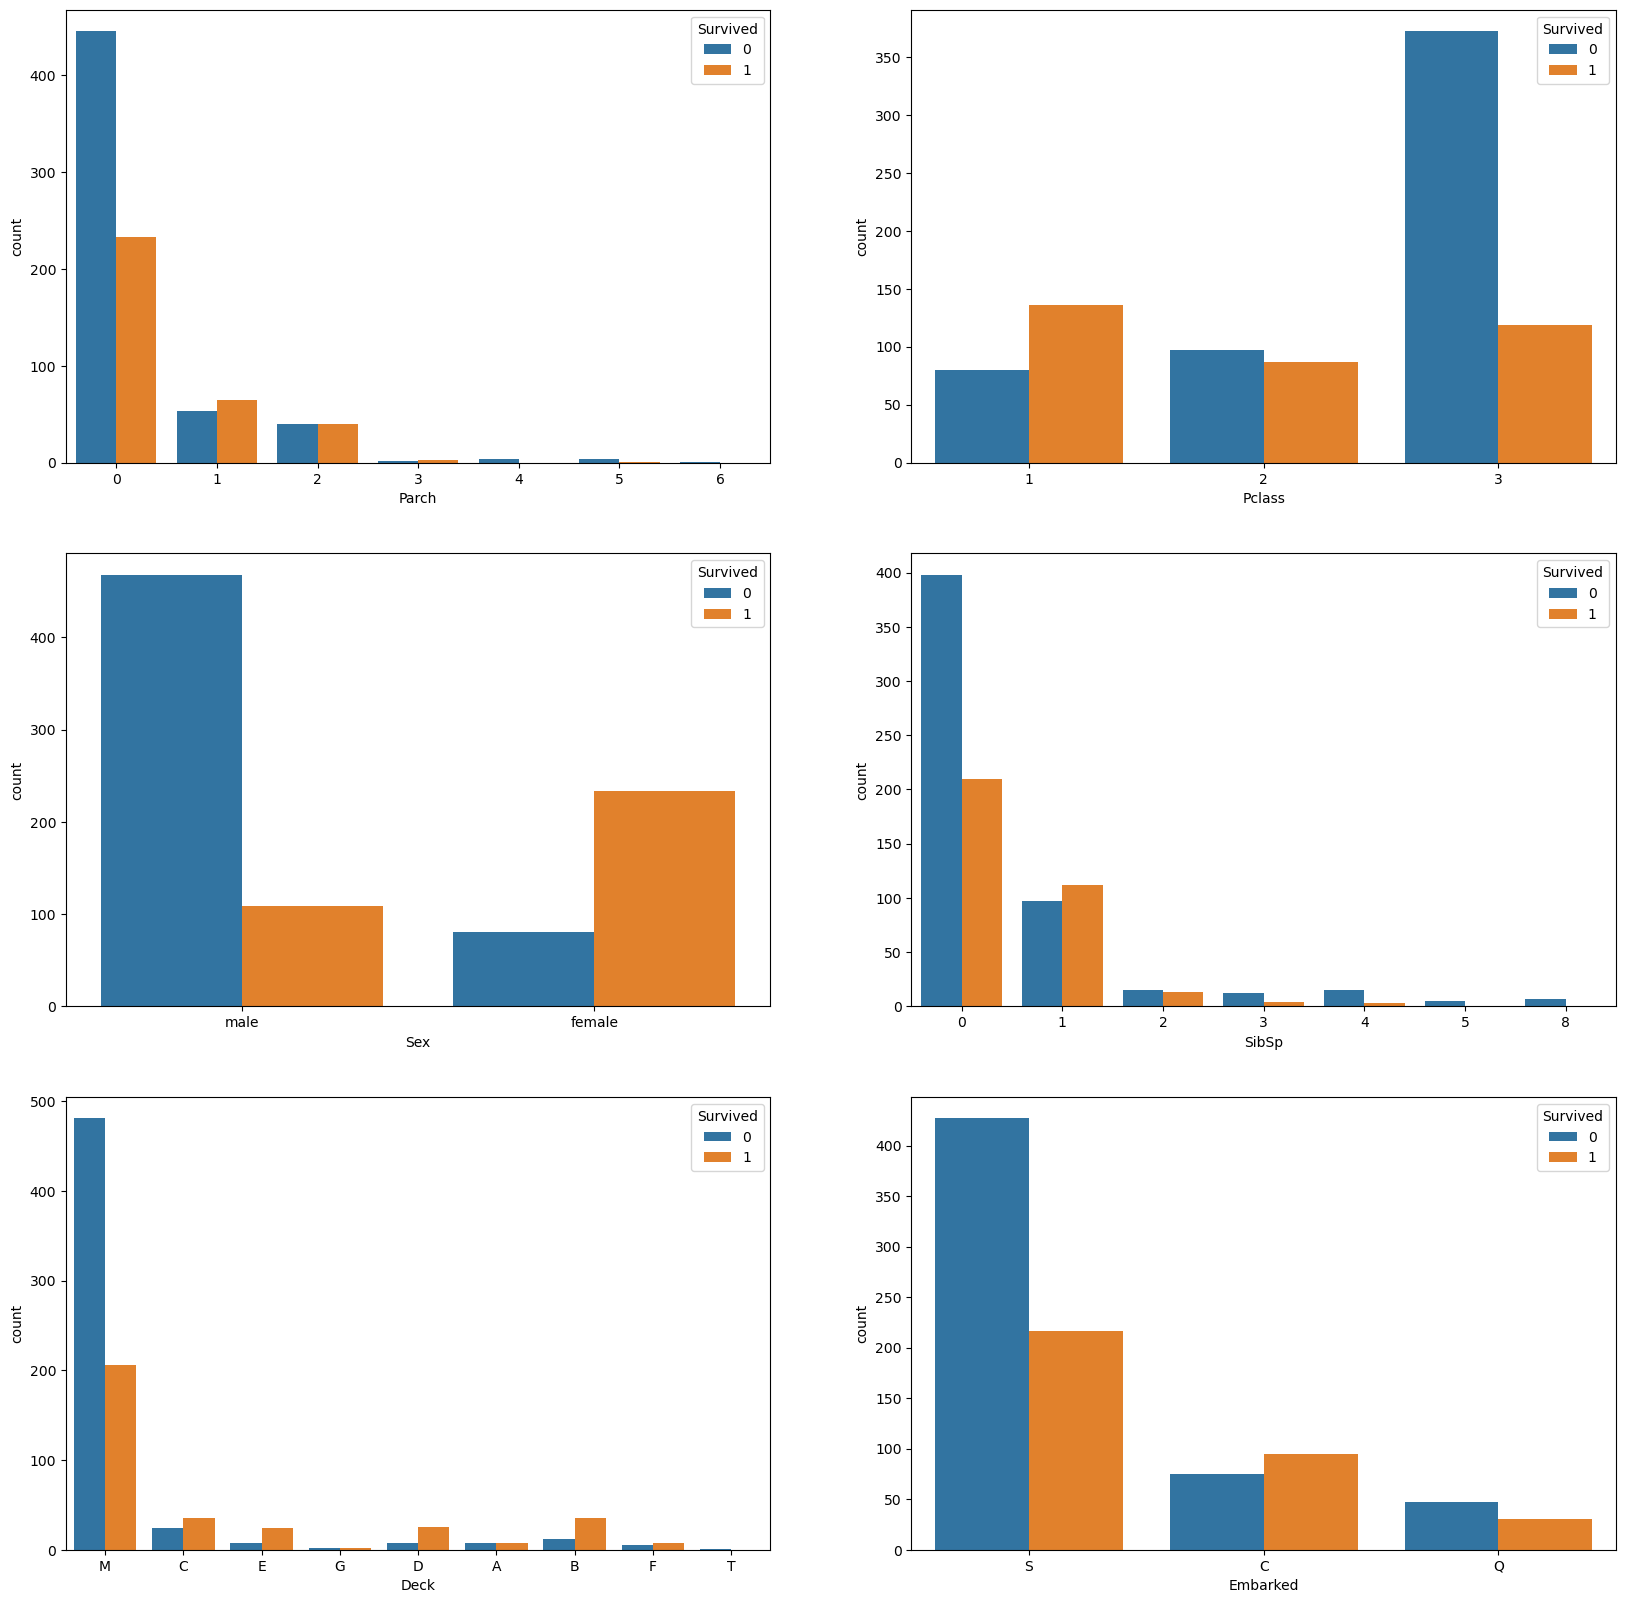

In [39]:
cat_features = ['Parch', 'Pclass', 'Sex', 'SibSp', 'Deck', 'Embarked']

fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize = (20,20))

for i, feature in enumerate(cat_features,start = 1):
    plt.subplot(3, 2 , i)
    sns.countplot(data = train_data, x = feature, hue = 'Survived')

# 4. Feature Engineering and Feature Selection

In [40]:
train_data['Deck'] = train_data['Deck'].replace(['A'], 1)
test_data['Deck'] = test_data['Deck'].replace(['A'], 1)
train_data['Deck'] = train_data['Deck'].replace(['B', 'C', 'D', 'E'], 2)
test_data['Deck'] = test_data['Deck'].replace(['B', 'C', 'D', 'E'], 2)
train_data['Deck'] = train_data['Deck'].replace(['F', 'G', 'T'], 3)
test_data['Deck'] = test_data['Deck'].replace(['F', 'G', 'T'], 3)
train_data['Deck'] = train_data['Deck'].replace(['M'], 4)
test_data['Deck'] = test_data['Deck'].replace(['M'], 4)

train_data['Deck'].value_counts()

4    687
2    171
3     18
1     15
Name: Deck, dtype: int64

<Axes: xlabel='Deck', ylabel='count'>

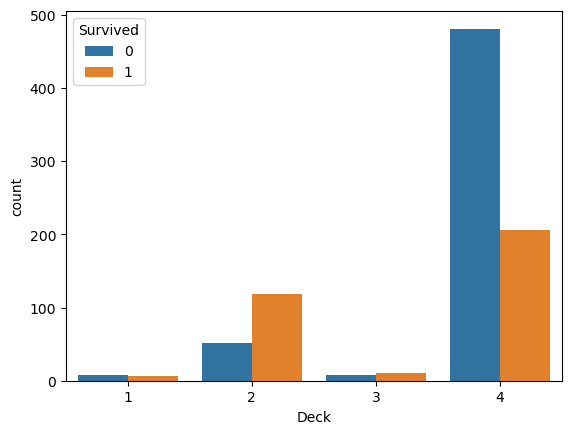

In [41]:
sns.countplot(data = train_data, x = 'Deck', hue = 'Survived')

In [42]:
cols = ['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex', 'Embarked']
ord_encoder = OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1)
ord_train_data = train_data.copy()
ord_test_data = test_data.copy()

ord_train_data[cols] = ord_encoder.fit_transform(train_data[cols])
ord_test_data[cols] = ord_encoder.transform(test_data[cols])

<Axes: >

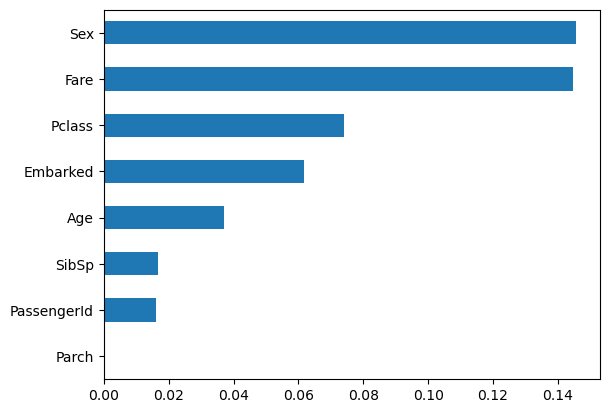

In [43]:
mi = mutual_info_classif(X = ord_train_data[cols], y = ord_train_data['Survived'], random_state = 1)
mi_plot = pd.Series(mi, cols).sort_values()
mi_plot.plot(kind='barh')

In [44]:
train_data['Family_size'] = train_data['SibSp'] + train_data['Parch'] + 1
test_data['Family_size'] = test_data['SibSp'] + test_data['Parch'] + 1

train_data.drop(['SibSp', 'Parch'], axis = 1, inplace = True)
test_data.drop(['SibSp', 'Parch'], axis = 1, inplace = True)

<Axes: xlabel='Fam_grp', ylabel='count'>

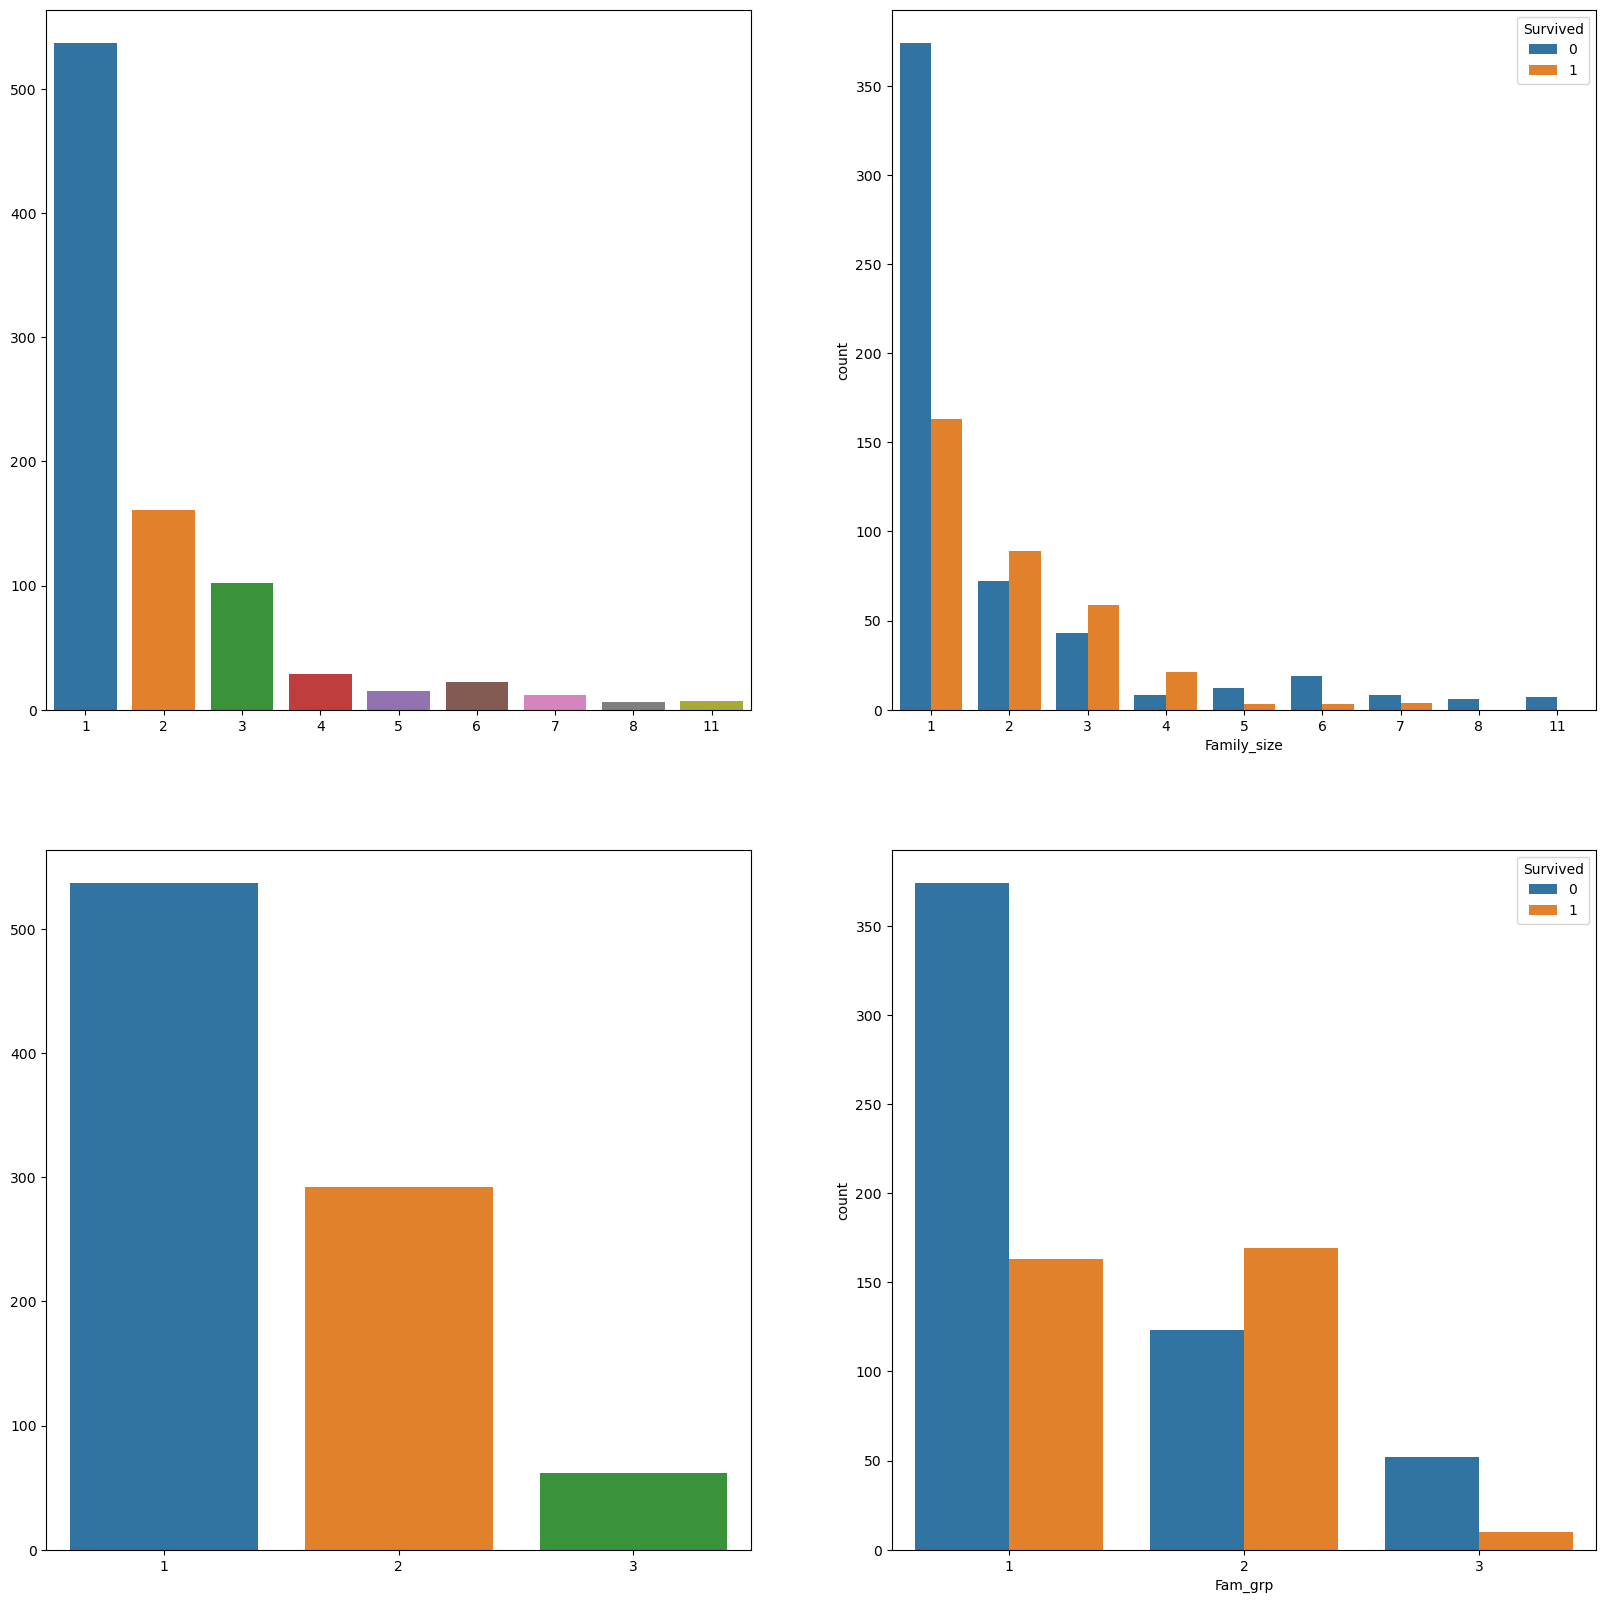

In [45]:
fig, axs = plt.subplots(ncols = 2, nrows = 2, figsize = (20,20))

sns.barplot(data = train_data, x = train_data['Family_size'].value_counts().index , y = train_data['Family_size'].value_counts().values ,ax = axs[0][0])

sns.countplot(data = train_data, x = 'Family_size', hue = 'Survived', ax = axs[0][1])

family_map = {1 : 1, 2: 2, 3: 2, 4: 2 , 5: 3, 6: 3, 7: 3 ,8: 3, 11: 3}

train_data['Fam_grp'] = train_data['Family_size'].map(family_map)
test_data['Fam_grp'] = test_data['Family_size'].map(family_map)

sns.barplot(data = train_data, x = train_data['Fam_grp'].value_counts().index, y = train_data['Fam_grp'].value_counts().values, ax = axs[1][0])
sns.countplot(data = train_data, x = 'Fam_grp', hue = 'Survived')

In [46]:
train_data.loc[train_data['Fare'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Embarked,Deck,Family_size,Fam_grp


<Axes: xlabel='Fare', ylabel='count'>

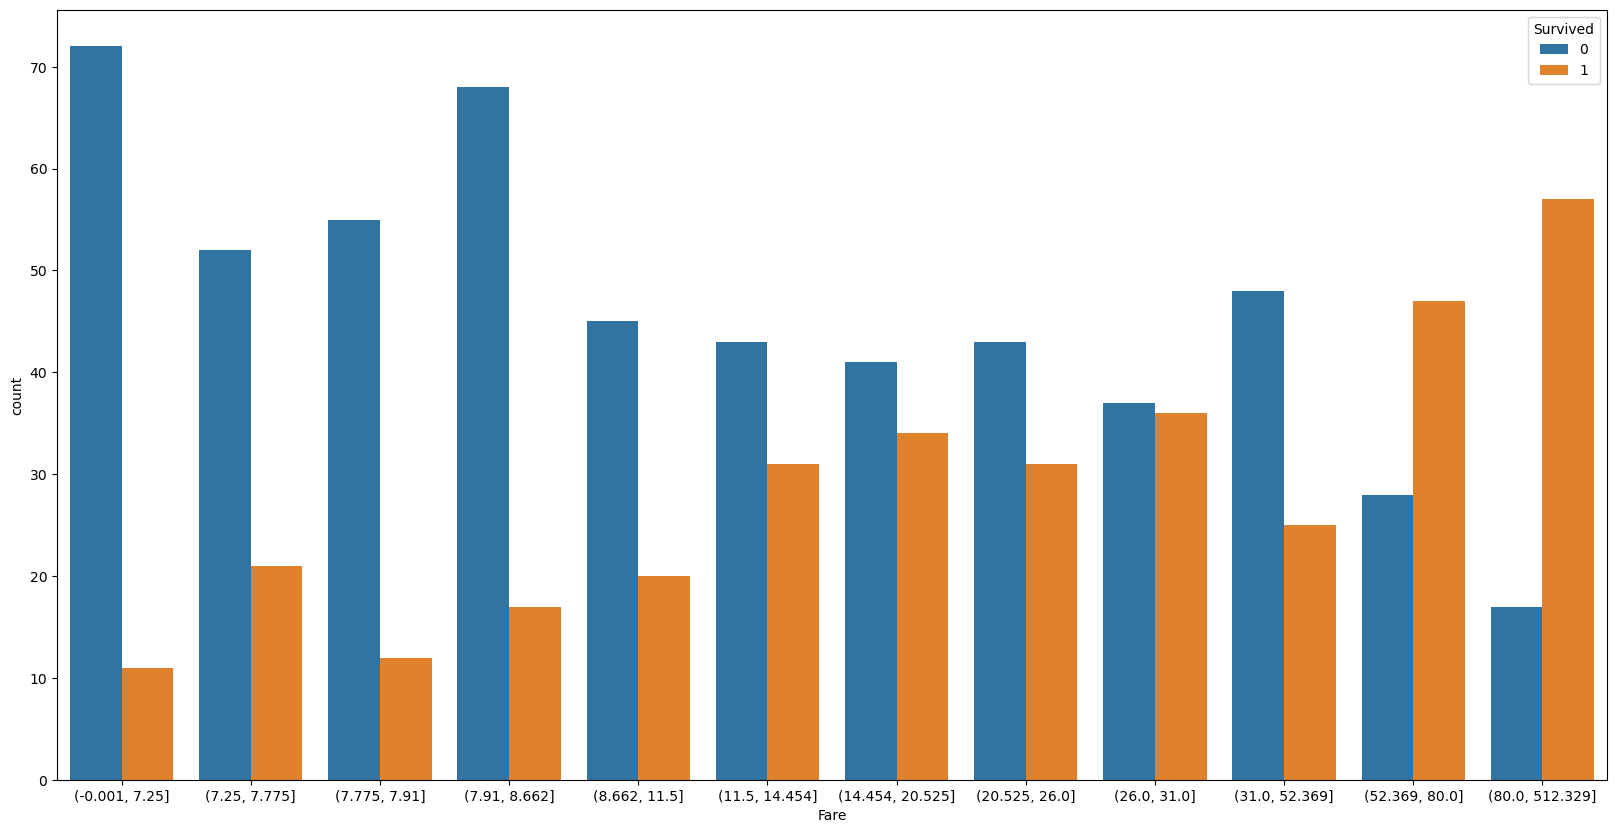

In [47]:
train_data['Fare'] = pd.qcut(train_data['Fare'], 12)
test_data['Fare'] = pd.qcut(test_data['Fare'], 12, duplicates = 'drop')

fig, ax = plt.subplots(figsize = (20,10))
sns.countplot(data = train_data, x = 'Fare', hue = 'Survived')

<Axes: xlabel='Age', ylabel='count'>

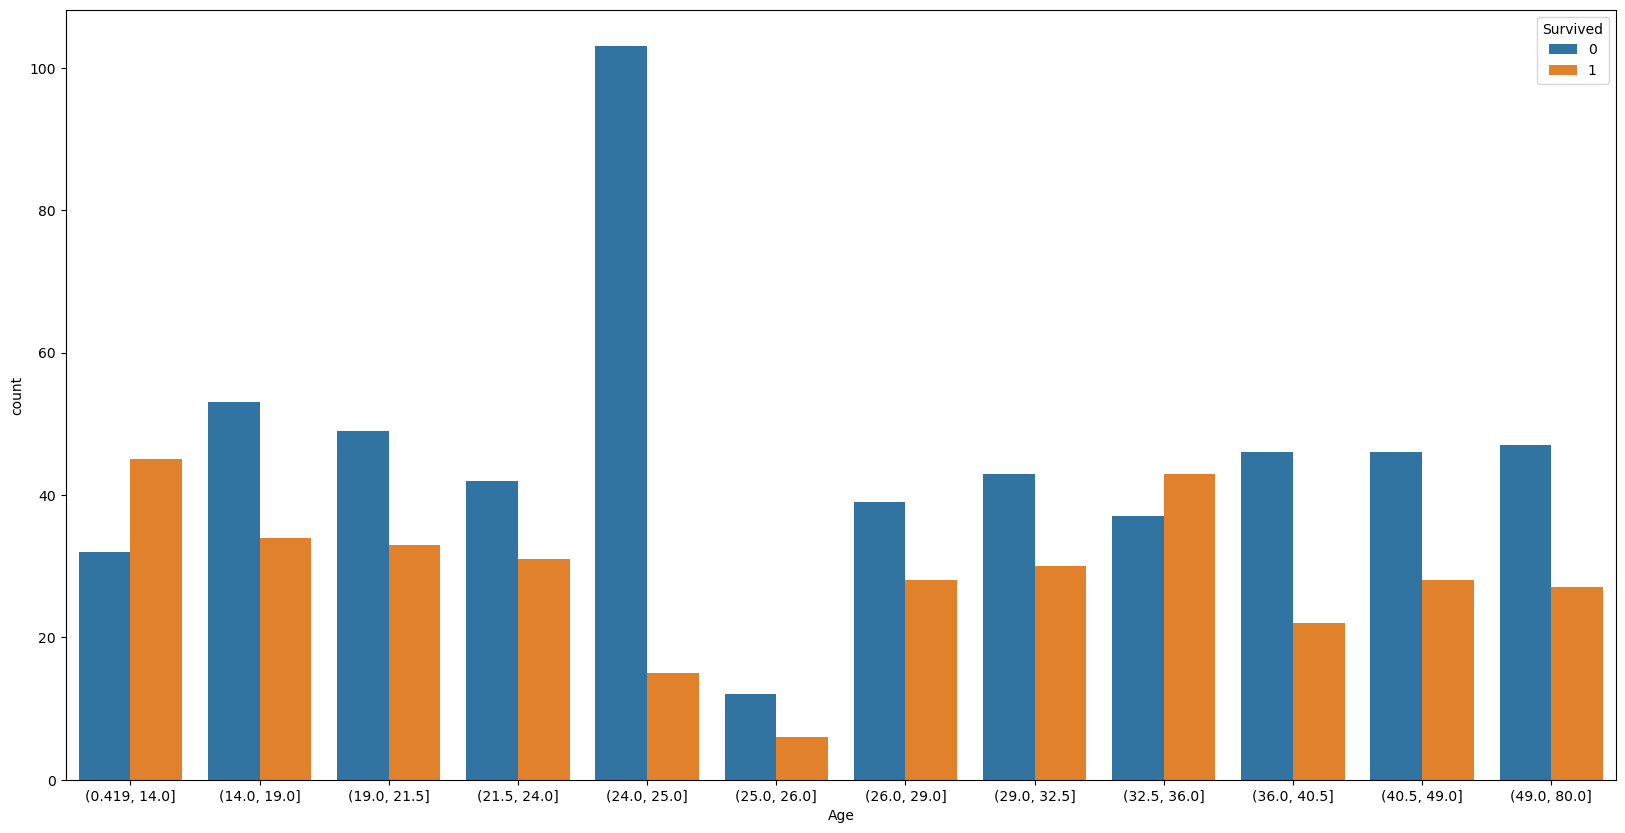

In [48]:
train_data['Age'] = pd.qcut(train_data['Age'], 12, duplicates = 'drop')
test_data['Age'] = pd.qcut(test_data['Age'], 12,  duplicates = 'drop')

train_data['Age']
fig, ax = plt.subplots(figsize = (20,10))
sns.countplot(data = train_data, x = 'Age', hue = 'Survived')

In [49]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Embarked,Deck,Family_size,Fam_grp
0,1,0,3,"Braund, Mr. Owen Harris",male,"(21.5, 24.0]",A/5 21171,"(-0.001, 7.25]",S,4,2,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,"(36.0, 40.5]",PC 17599,"(52.369, 80.0]",C,2,2,2
2,3,1,3,"Heikkinen, Miss. Laina",female,"(25.0, 26.0]",STON/O2. 3101282,"(7.91, 8.662]",S,4,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,"(32.5, 36.0]",113803,"(52.369, 80.0]",S,2,2,2
4,5,0,3,"Allen, Mr. William Henry",male,"(32.5, 36.0]",373450,"(7.91, 8.662]",S,4,1,1


In [50]:
train_data['Fam_grp'].info

<bound method Series.info of 0      2
1      2
2      1
3      2
4      1
      ..
886    1
887    1
888    2
889    1
890    1
Name: Fam_grp, Length: 891, dtype: int64>

In [51]:
labels = ['Sex', 'Embarked', 'Age', 'Fare']

label_encoder = LabelEncoder()


for feature in labels:
    train_data[feature] = label_encoder.fit_transform(train_data[feature])
    test_data[feature] = label_encoder.fit_transform(test_data[feature])


one_hot_encoded_train = pd.get_dummies(train_data, columns = ['Sex', 'Embarked'])
one_hot_encoded_test = pd.get_dummies(test_data, columns = ['Sex', 'Embarked'])

# 5. Model

In [52]:
one_hot_encoded_train.head()

,PassengerId,Survived,Pclass,Name,Age,Ticket,Fare,Deck,Family_size,Fam_grp,Sex_0,Sex_1,Embarked_0,Embarked_1,Embarked_2
0,1,0,3,"Braund, Mr. Owen Harris",3,A/5 21171,0,4,2,2,0,1,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",9,PC 17599,10,2,2,2,1,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",5,STON/O2. 3101282,3,4,1,1,1,0,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",8,113803,10,2,2,2,1,0,0,0,1
4,5,0,3,"Allen, Mr. William Henry",8,373450,3,4,1,1,0,1,0,0,1


In [53]:
one_hot_encoded_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PassengerId  418 non-null    int64 
 1   Pclass       418 non-null    int64 
 2   Name         418 non-null    object
 3   Age          418 non-null    int64 
 4   Ticket       418 non-null    object
 5   Fare         418 non-null    int64 
 6   Deck         418 non-null    int64 
 7   Family_size  418 non-null    int64 
 8   Fam_grp      418 non-null    int64 
 9   Sex_0        418 non-null    uint8 
 10  Sex_1        418 non-null    uint8 
 11  Embarked_0   418 non-null    uint8 
 12  Embarked_1   418 non-null    uint8 
 13  Embarked_2   418 non-null    uint8 
dtypes: int64(7), object(2), uint8(5)
memory usage: 31.6+ KB


In [54]:
train_X = one_hot_encoded_train[['Pclass', 'Age', 'Fare', 'Sex_0',
       'Sex_1', 'Embarked_0', 'Embarked_1', 'Embarked_2', 'Deck', 'Fam_grp']]
train_y = one_hot_encoded_train['Survived']
test_X = one_hot_encoded_test[['Pclass', 'Age', 'Fare','Sex_0',
       'Sex_1', 'Embarked_0', 'Embarked_1', 'Embarked_2', 'Deck', 'Fam_grp']]

In [55]:
X_train, X_val, y_train, y_val = train_test_split(train_X, train_y, train_size = 0.8)

In [56]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 11 to 623
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Pclass      712 non-null    int64
 1   Age         712 non-null    int64
 2   Fare        712 non-null    int64
 3   Sex_0       712 non-null    uint8
 4   Sex_1       712 non-null    uint8
 5   Embarked_0  712 non-null    uint8
 6   Embarked_1  712 non-null    uint8
 7   Embarked_2  712 non-null    uint8
 8   Deck        712 non-null    int64
 9   Fam_grp     712 non-null    int64
dtypes: int64(5), uint8(5)
memory usage: 36.9 KB


baseline model before feature engineering and selction

In [57]:
# for i in range(2,15):    
#     baseline = RandomForestClassifier(criterion = 'gini',
#                                       n_estimators = 1000, 
#                                       max_depth = 5,
#                                       min_samples_split = 4,
#                                       max_leaf_nodes = 10,
#                                       random_state = 1)
#     baseline.fit(X_train, y_train)
#     predictions = baseline.predict(test_X)
#     predictions_train = baseline.predict(X_train)
#     predictions_val = baseline.predict(X_val)
#     print('The accuracy of trianing set for {} is {}'.format(i, accuracy_score(predictions_train, y_train)))
#     print('The accuracy of test set for {} is {} '.format(i, accuracy_score(predictions_val, y_val)))

In [58]:
model = RandomForestClassifier(criterion = 'gini',
                              max_depth = 5,
                              min_samples_split = 4,
                              n_estimators = 1000,
                               max_leaf_nodes = 10,
                               random_state = 1,
                               n_jobs = -1,
                               verbose = 1, 
                               oob_score = True,
                               max_features = 'auto'
                              )

In [59]:
model.fit(train_X ,train_y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.7s finished


RandomForestClassifier(max_depth=5, max_features='auto', max_leaf_nodes=10,
                       min_samples_split=4, n_estimators=1000, n_jobs=-1,
                       oob_score=True, random_state=1, verbose=1)

In [60]:
predictions = model.predict(test_X)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.3s finished


In [61]:
model.oob_score_

0.8181818181818182

In [62]:
output = pd.DataFrame({'PassengerId' : submission.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index = False)

In [63]:
output.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
